Dataset shape: (1025, 14)
Dataset after encoding and dropping NA values:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  
Dataset: Preprocessing successful.


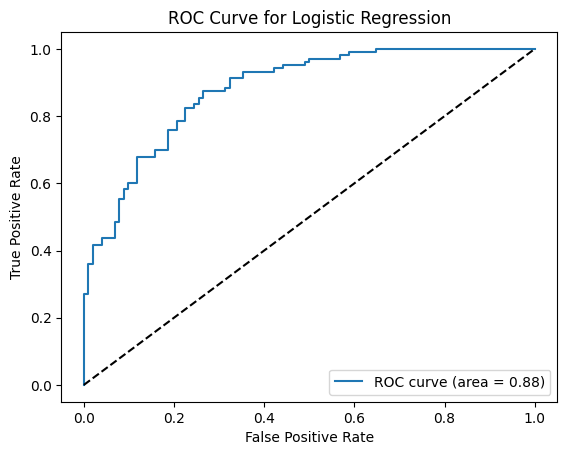

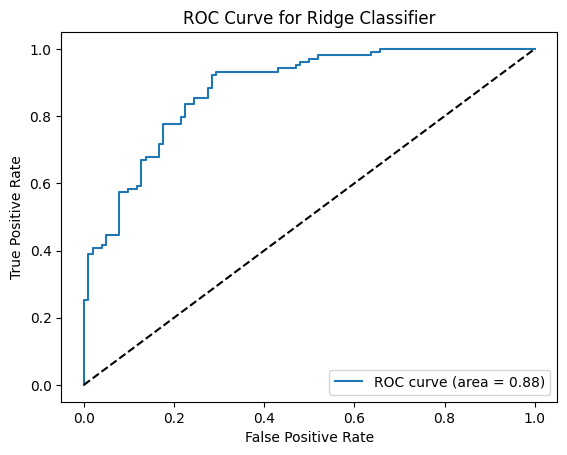

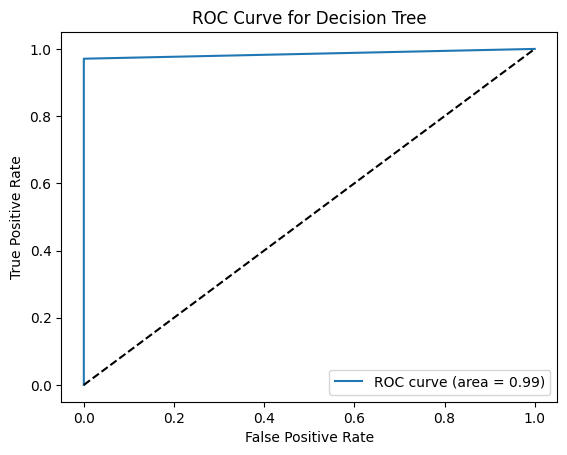

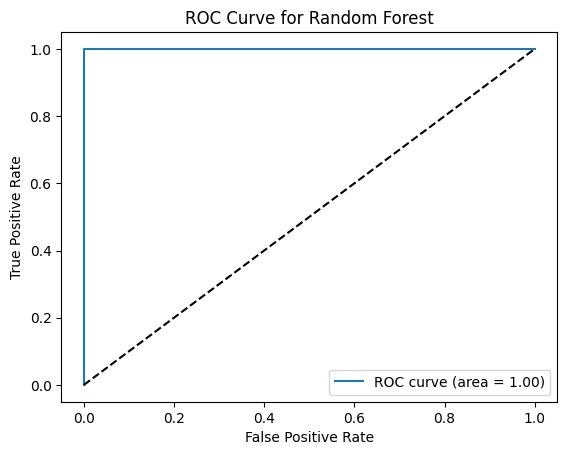

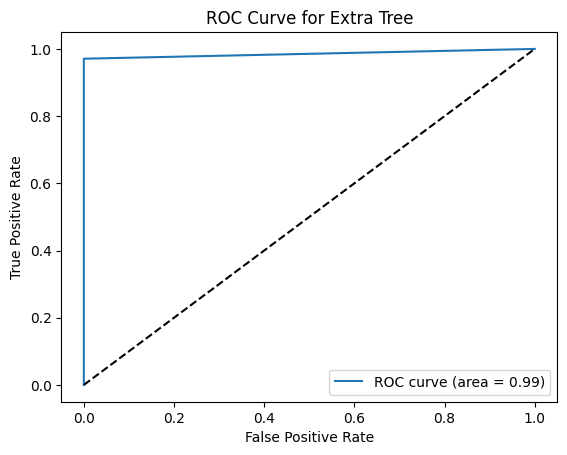

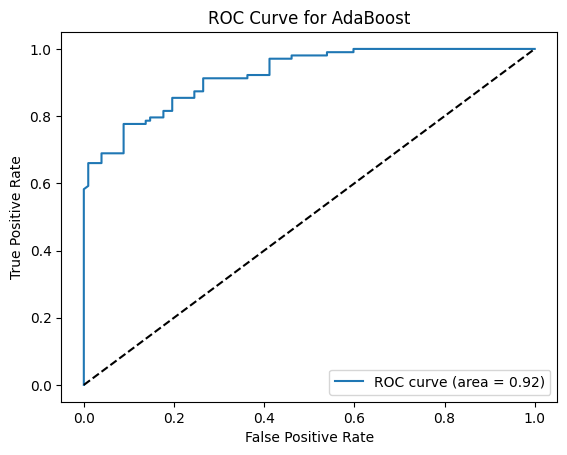

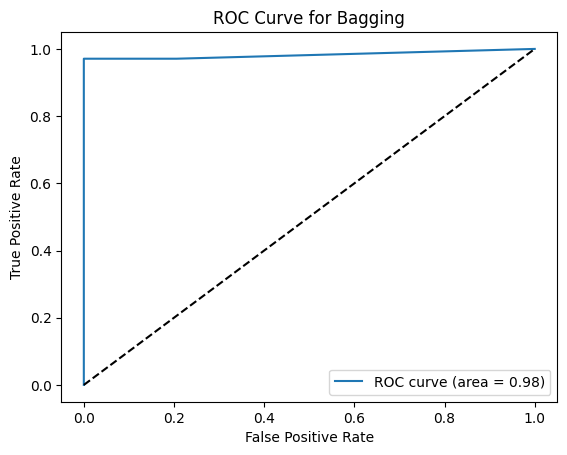

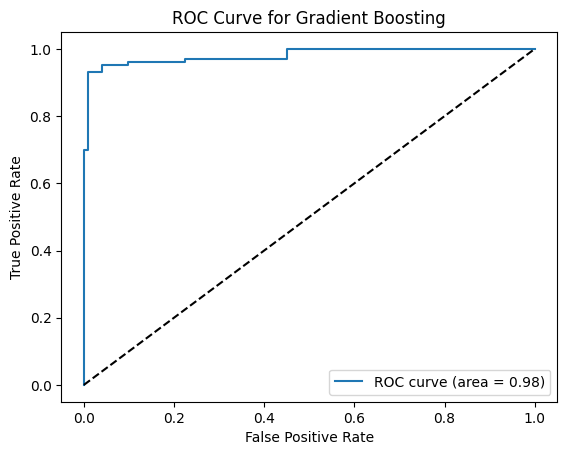

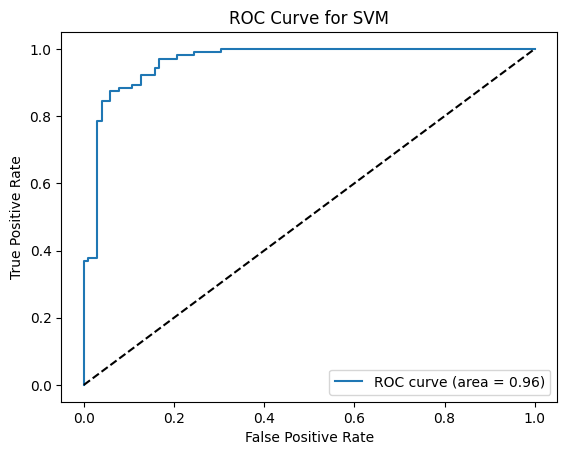

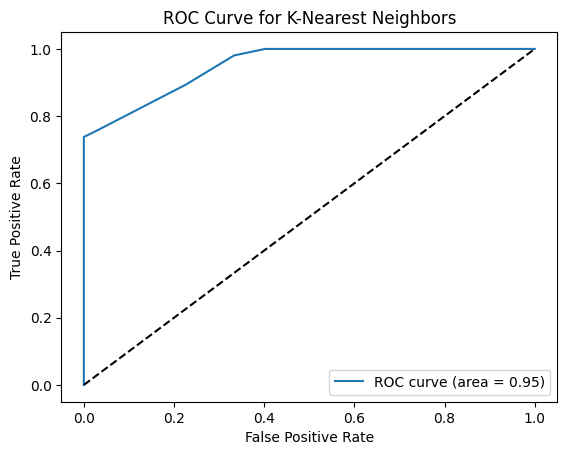

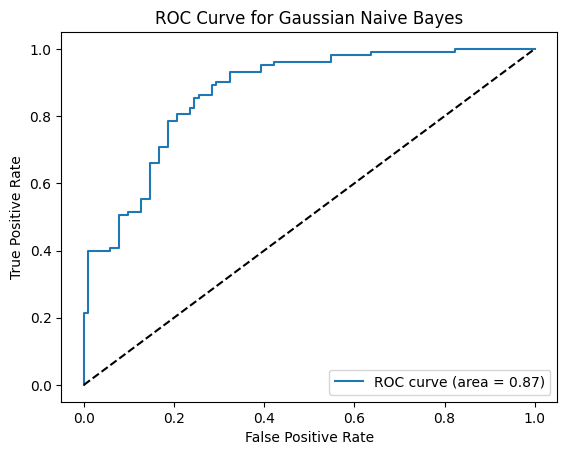

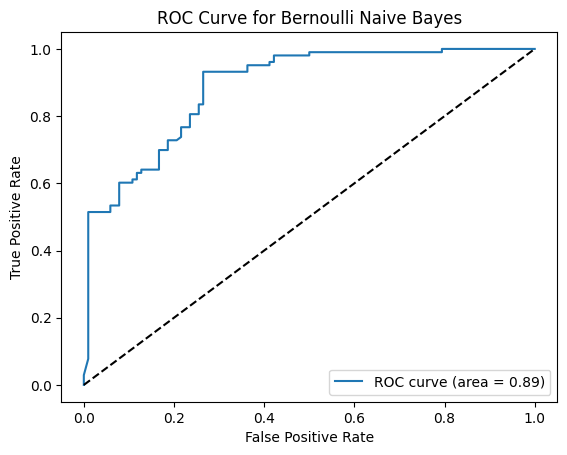

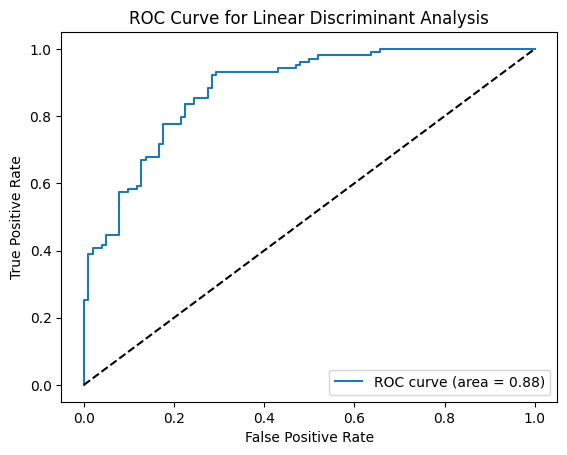

Using 820 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/205 [00:00<?, ?it/s]

SHAP Summary Plot for Logistic Regression:


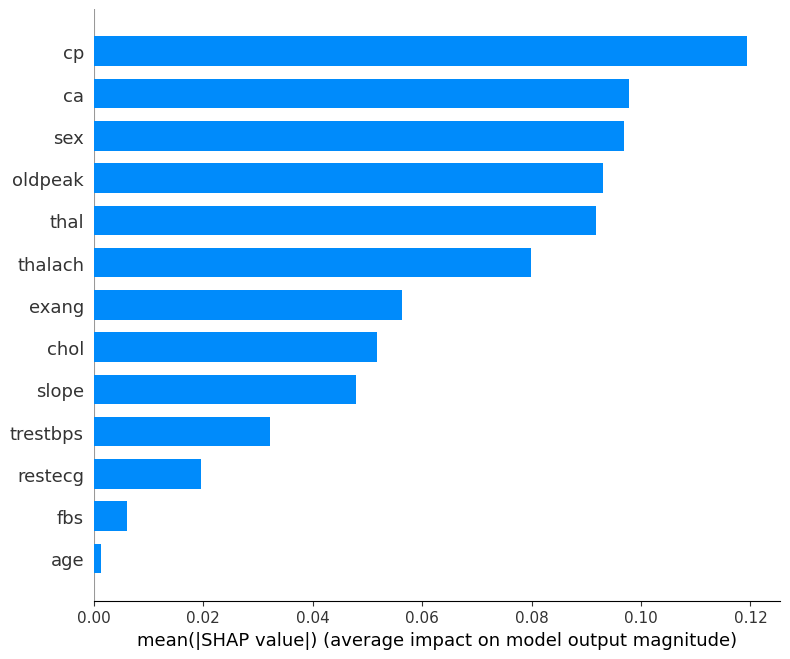

LIME Analysis for Logistic Regression...


Using 820 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/205 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, cohen_kappa_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    BaggingClassifier, ExtraTreesClassifier, VotingClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import shap
import lime
from lime import lime_tabular

# Set the number of cores to use for parallel processing
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # Set this to the number of cores you want to use

# Load the CARDIA dataset
dataset = pd.read_csv('heart.csv')

# Function to preprocess the data and calculate the correlation matrix
def preprocess_data(df):
    # Filter numeric columns
    numeric_columns = df.select_dtypes(include=np.number).columns
    
    # Calculate the correlation matrix for numeric columns
    corr_matrix = df[numeric_columns].corr()
    
    # Print the shape of the dataset
    print(f"Dataset shape: {df.shape}")
    
    # Handle missing values (if any)
    df = df.dropna()
    
    # Encode categorical variables (if any)
    for column in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df.loc[:, column] = le.fit_transform(df[column]) 
    
    # Print the first few rows of the dataset
    print(f"Dataset after encoding and dropping NA values:\n{df.head()}")
    
    # Check if the 'target' column exists
    if 'target' in df.columns:
        # Split data into features and target variable
        X = df.drop('target', axis=1)  # Assuming 'target' is the column name for the label
        y = df['target']
        
        # Scale the data
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        return X_train, X_test, y_train, y_test, corr_matrix, df.columns[:-1]
    else:
        return None, None, None, None, corr_matrix, None

# Function to calculate specificity
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return tn / (tn + fp)

# Function to convert decision function outputs to probabilities
def decision_function_to_proba(decision_function_values):
    return 1 / (1 + np.exp(-decision_function_values))

# Function to evaluate models
def evaluate_models(X_train, X_test, y_train, y_test, feature_names):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=10000),  # Increased max_iter
        'Ridge Classifier': RidgeClassifier(),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Extra Tree': ExtraTreeClassifier(),
        'AdaBoost': AdaBoostClassifier(algorithm='SAMME'),
        'Bagging': BaggingClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'SVM': SVC(probability=True),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Gaussian Naive Bayes': GaussianNB(),
        'Bernoulli Naive Bayes': BernoulliNB(),
        'Linear Discriminant Analysis': LinearDiscriminantAnalysis()
    }
    
    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        else:
            # Use decision function and convert to probabilities
            y_pred_proba = decision_function_to_proba(model.decision_function(X_test)) if hasattr(model, "decision_function") else None
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        sensitivity = recall  # Sensitivity is same as recall in binary classification
        specificity = specificity_score(y_test, y_pred)
        kappa = cohen_kappa_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
        mean_cv_auc = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean() if y_pred_proba is not None else None
        
        metrics = {
            'Model': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Cohen Kappa': kappa,
            'AUC': auc,
            'Mean CV AUC': mean_cv_auc,
            'Confusion Matrix': confusion_matrix(y_test, y_pred),
            'model': model  # Store the trained model for SHAP and LIME analysis
        }
        
        if y_pred_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            plt.figure()
            plt.plot(fpr, tpr, label=f'ROC curve (area = {metrics["AUC"]:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve for {name}')
            plt.legend(loc="lower right")
            plt.show()
        
        results[name] = metrics
    
    return results

# Process the dataset
X_train, X_test, y_train, y_test, corr_matrix, feature_names = preprocess_data(dataset)

if X_train is not None:
    print(f"Dataset: Preprocessing successful.")
    model_results = evaluate_models(X_train, X_test, y_train, y_test, feature_names)
else:
    print(f"Dataset: Target column not found or empty dataset.")
    model_results = {}

# SHAP and LIME analysis for all models
for model_name, result in model_results.items():
    model = result['model']
    
    # Select the appropriate SHAP explainer
    if isinstance(model, (DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreeClassifier, ExtraTreesClassifier)):
        explainer = shap.TreeExplainer(model)
    else:
        explainer = shap.KernelExplainer(model.predict, X_train)
    
    shap_values = explainer.shap_values(X_test)
    
    if isinstance(shap_values, list) and len(shap_values) > 1:
        shap_values = shap_values[1]
    
    print(f"SHAP Summary Plot for {model_name}:")
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar")
    plt.show()
    
    # LIME Analysis
    if hasattr(model, "predict_proba"):
        print(f"LIME Analysis for {model_name}...")
        lime_explainer = lime_tabular.LimeTabularExplainer(X_train, 
                                                          feature_names=feature_names, 
                                                          class_names=['No Heart Disease', 'Heart Disease'], 
                                                          discretize_continuous=True)
        
        lime_exp = lime_explainer.explain_instance(X_test[0], model.predict_proba, num_features=10)
        lime_exp.show_in_notebook(show_table=True, show_all=False)
    else:
        print(f"LIME Analysis skipped for {model_name} as it does not support predict_proba.")

# Display confusion matrices
for model_name, result in model_results.items():
    cm = result['Confusion Matrix']
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
